# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

N.B. The variable naming convention:

- `.lt..` denotes long-term data (monthly over years)
- `.st..` denotes short-term data (daily over one year)
- `...oc` denotes one-column data (without exogenous variables)
- `...mc` denotes multi-column data (with exogenous variables)
- `g....` in front of a variable denotes that it will be the GRU variant (LSTM by default)

- `sc..` means scaled
- `..tr`, `..vl`, `..ts` mean training, validation, and test sets respectively

- `X..` is the input (I know this would typically indicate a constant variable in Python, but it is more consistent with mathematical notation)
- `y..` is the label

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Type, Optional
import pandera as pa
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta

import meteostat as met

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [7]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [8]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [9]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [10]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [11]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [12]:
# timeseries data breakout
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [13]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [14]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [15]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [16]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat, sun_data], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [17]:
mean_wdat.head()

,sun_eff,tavg,wspd
2011-01-01,0.018301,5.300,14.400
2011-02-01,0.026512,7.500,18.000
2011-03-01,0.068665,8.925,15.775
2011-04-01,0.117791,13.100,13.550
2011-05-01,0.125091,13.580,14.300


In [18]:
ltoc = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

In [19]:
scaler_ltoc = MinMaxScaler(feature_range=(0, 1))

In [20]:
agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [21]:
def col_Xy(col: Series, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(col)-seasonal_order):
    window = [a for a in col[i:i+seasonal_order]]
    X.append(window)
    label = col[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

The function takes the previous `seasonal_order` number of values and then labels them with the `seasonal_order + 1`-th value

In [22]:
SEASON_LTLF = 11

11 is chosen because we want to predict the 12th value based on the previous 11. The idea is that the window size (ML `seasonal_order`) is the traditional seasonal order - 1.

In [23]:
Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)

In [24]:
Xtr_ltoc[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [25]:
ytr_ltoc[0]

array([0.82318279])

In [26]:
Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)

### Running the LTLF

First I build the model, as shown in much of the documentation, StackOverflow recommendations, and various tutorials online

In [27]:

ltoc_model = Sequential()
ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
ltoc_model.add(LSTM(128, return_sequences=True))
ltoc_model.add(LSTM(128))
ltoc_model.add(Dense(8, 'relu'))
ltoc_model.add(Dense(1, 'linear'))

ltoc_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

I set a checkpoint for the epochs so that we can load the optimal model later and I compile the model.

In [28]:
cp = ModelCheckpoint('models/ltoc_model.keras', save_best_only=True)
ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Finally, I fit the model.

In [29]:
ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1702 - root_mean_squared_error: 0.4123 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3456
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0704 - root_mean_squared_error: 0.2652 - val_loss: 0.1478 - val_root_mean_squared_error: 0.3845
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0824 - root_mean_squared_error: 0.2868 - val_loss: 0.1181 - val_root_mean_squared_error: 0.3437
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0635 - root_mean_squared_error: 0.2519 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3528
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0705 - root_mean_squared_error: 0.2652 - val_loss: 0.1182 - val_root_mean_squared_error: 0.3439
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3346
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0628 - roo

Load the best model.

In [30]:
ltoc_model = load_model('models/ltoc_model.keras')

I unscale the data.

In [31]:
pred_ltoc = ltoc_model.predict(Xts_ltoc)
pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)

yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


I plot the predicted values on the actuals to see how well the model did.

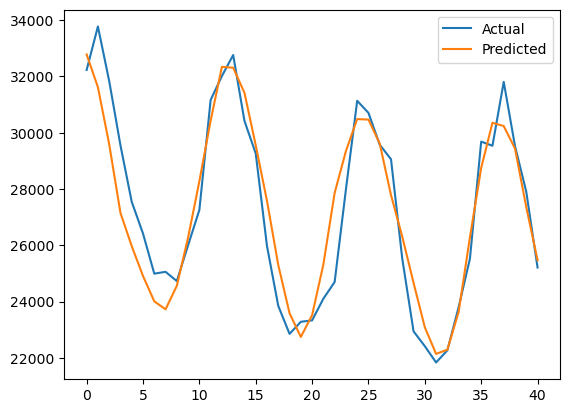

In [32]:
plt.plot(yts_ltoc, label='Actual')
plt.plot(pred_ltoc, label='Predicted')
plt.legend()
plt.show()

And finally I get the MAPE.

In [33]:
print(f"MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%")

MAPE: 3.415%


This process will be repeated 7 more times with LSTM/GRU and `..oc`, `..mc` inputs.

### LTLF with Exogenous Variables

In [34]:
def df_Xy(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(df)-seasonal_order):
    row = [a for a in df[i:i+seasonal_order]]
    X.append(row)
    label = df[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

This is a modified col_Xy built for `..mc` datasets.

In [35]:
ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

In [36]:
scaler_ltmc = MinMaxScaler(feature_range=(0, 1))

sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)

In [37]:
ltmc_model = Sequential()
ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
ltmc_model.add(LSTM(512, return_sequences=True))
ltmc_model.add(LSTM(256))
ltmc_model.add(Dense(32, 'relu'))
ltmc_model.add(Dense(4, 'linear'))

ltmc_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 11, 512)        │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
cp = ModelCheckpoint('models/ltmc_model.keras', save_best_only=True)
ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - loss: 0.2080 - root_mean_squared_error: 0.4549 - val_loss: 0.0961 - val_root_mean_squared_error: 0.3100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0817 - root_mean_squared_error: 0.2847 - val_loss: 0.0919 - val_root_mean_squared_error: 0.3031
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0616 - root_mean_squared_error: 0.2481 - val_loss: 0.1119 - val_root_mean_squared_error: 0.3345
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0833 - root_mean_squared_error: 0.2885 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3221
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2828
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0533 - root_mean_squared_error: 0.2308 - val_loss: 0.0813 - val_root_mean_squared_error: 0.2852
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0569 - r

In [39]:
ltmc_model = load_model('models/ltmc_model.keras')
pred_ltmc = ltmc_model.predict(Xts_ltmc)
pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]

yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


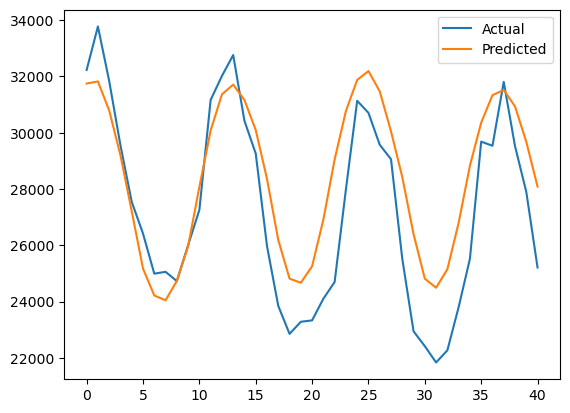

MAPE: 6.335%


In [40]:
plt.plot(yts_ltmc, label='Actual')
plt.plot(pred_ltmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_ltmc, pred_ltmc)*100:.3f}%")

### STLF

In [41]:
SEASON_STLF = 6

In [42]:
stoc = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [43]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [44]:
ldn_dwdat = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_dwdat = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_dwdat = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [45]:
sun_dfactor = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_ddata = sun_dfactor[(sun_dfactor.index >= pd.to_datetime("2022-01-01")) & (sun_dfactor.index <= pd.to_datetime("2022-12-31"))]

combined_dwdat = pd.concat([ldn_dwdat, edi_dwdat, cdf_dwdat, sun_ddata], axis=1)

mean_dwdat = combined_dwdat.T.groupby(combined_dwdat.columns).agg("mean").T

In [46]:
agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")

In [47]:
scaler_stoc = MinMaxScaler(feature_range=(0, 1))

sctr_stoc = scaler_stoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
scvl_stoc = scaler_stoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
scts_stoc = scaler_stoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)

In [48]:
stoc_model = Sequential()
stoc_model.add(InputLayer((SEASON_STLF, 1)))
stoc_model.add(LSTM(128, return_sequences=True))
stoc_model.add(LSTM(128))
stoc_model.add(Dense(8, 'relu'))
stoc_model.add(Dense(1, 'linear'))

stoc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 6, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
cp = ModelCheckpoint('models/stoc_model.keras', save_best_only=True)
stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0447 - root_mean_squared_error: 0.1970 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2428
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2401
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0559 - val_root_mean_squared_error: 0.2364
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0544 - val_root_mean_squared_error: 0.2332
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1976
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - root_mean_squared_error: 0.0731 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1638
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

In [50]:
stoc_model = load_model('models/stoc_model.keras')

pred_stoc = stoc_model.predict(Xts_stoc)
pred_stoc = scaler_stoc.inverse_transform(pred_stoc)

yts_stoc = scaler_stoc.inverse_transform(yts_stoc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


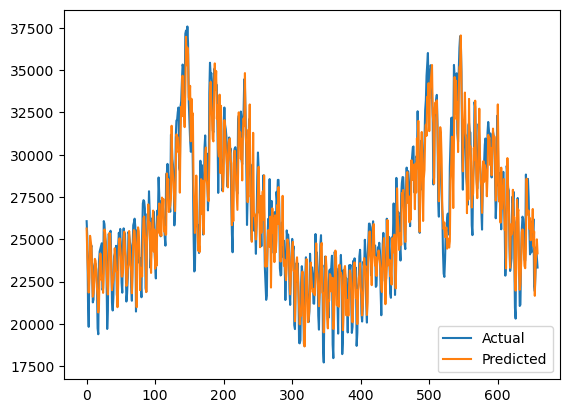

MAPE: 4.671%


In [51]:
plt.plot(yts_stoc, label='Actual')
plt.plot(pred_stoc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_stoc, pred_stoc)*100:.3f}%")

### STLF with Exogenous Variables

In [52]:
stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")

In [53]:
scaler_stmc = MinMaxScaler(feature_range=(0, 1))

sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)

In [54]:
stmc_model = Sequential()
stmc_model.add(InputLayer((SEASON_STLF, 4)))
stmc_model.add(LSTM(512, return_sequences=True))
stmc_model.add(LSTM(256))
stmc_model.add(Dense(32, 'relu'))
stmc_model.add(Dense(4, 'linear'))

stmc_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 512)         │     1,058,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,854,628 (7.07 MB)

 Trainable params: 1,854,628 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
cp = ModelCheckpoint('models/stmc_model.keras', save_best_only=True)
stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.2229 - root_mean_squared_error: 0.4714 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2379
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2691
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0429 - root_mean_squared_error: 0.2070 - val_loss: 0.0647 - val_root_mean_squared_error: 0.2543
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2418
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0370 - root_mean_squared_error: 0.1922 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2346
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0317 - roo

In [56]:
stmc_model = load_model('models/stmc_model.keras')

pred_stmc = stmc_model.predict(Xts_stmc)
pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]

yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


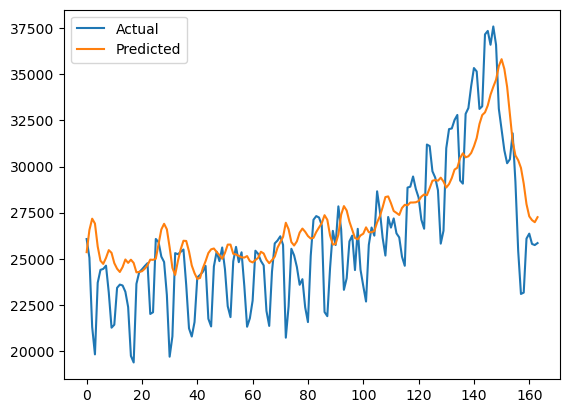

MAPE: 8.027%


In [57]:
plt.plot(yts_stmc, label='Actual')
plt.plot(pred_stmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_stmc, pred_stmc)*100:.3f}%")

## GRU (Gated Recurrent Unit)

### LTLF

In [58]:
scaler_gltoc = MinMaxScaler(feature_range=(0, 1))

In [59]:
agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])

In [60]:
Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)

In [61]:
gltoc_model = Sequential()
gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
gltoc_model.add(GRU(128, return_sequences=True))
gltoc_model.add(GRU(128))
gltoc_model.add(Dense(8, 'relu'))
gltoc_model.add(Dense(1, 'linear'))

In [62]:
cp = ModelCheckpoint('models/gltoc_model.keras', save_best_only=True)
gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [63]:
gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 0.1821 - root_mean_squared_error: 0.4254 - val_loss: 0.1070 - val_root_mean_squared_error: 0.3272
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0625 - root_mean_squared_error: 0.2495 - val_loss: 0.1221 - val_root_mean_squared_error: 0.3494
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0670 - root_mean_squared_error: 0.2587 - val_loss: 0.0959 - val_root_mean_squared_error: 0.3097
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0493 - root_mean_squared_error: 0.2213 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2897
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0467 - roo

In [64]:
gltoc_model = load_model('models/gltoc_model.keras')

pred_gltoc = gltoc_model.predict(Xts_gltoc)
pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)

yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


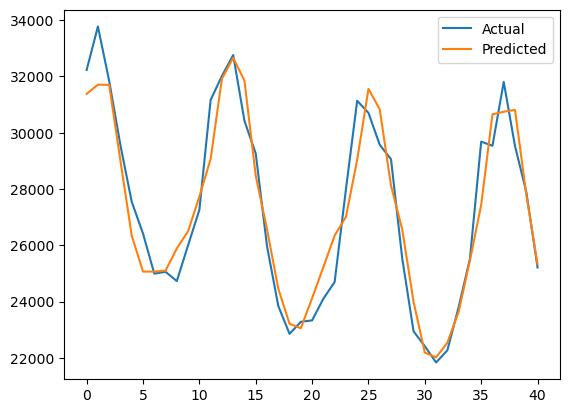

In [65]:
plt.plot(yts_gltoc, label='Actual')
plt.plot(pred_gltoc, label='Predicted')
plt.legend()
plt.show()

In [66]:
print(f"MAPE: {mean_absolute_percentage_error(yts_gltoc, pred_gltoc)*100:.3f}%")

MAPE: 2.906%


### LTLF with Exogenous Variables

In [67]:
scaler_gltmc = MinMaxScaler(feature_range=(0, 1))

sctr_gltmc = scaler_gltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
scvl_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
scts_gltmc = scaler_gltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])

Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)

In [68]:
gltmc_model = Sequential()
gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
gltmc_model.add(GRU(512, return_sequences=True))
gltmc_model.add(GRU(256))
gltmc_model.add(Dense(32, 'relu'))
gltmc_model.add(Dense(4, 'linear'))

gltmc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 11, 512)        │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
cp = ModelCheckpoint('models/gltmc_model.keras', save_best_only=True)
gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - loss: 0.2230 - root_mean_squared_error: 0.4715 - val_loss: 0.1100 - val_root_mean_squared_error: 0.3316
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0733 - root_mean_squared_error: 0.2707 - val_loss: 0.0974 - val_root_mean_squared_error: 0.3121
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2985
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0529 - root_mean_squared_error: 0.2298 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2429
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2240
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0344 - root_mean_squared_error: 0.1853 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0238

In [70]:
gltmc_model = load_model('models/gltmc_model.keras')

pred_gltmc = gltmc_model.predict(Xts_gltmc)
pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]

yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


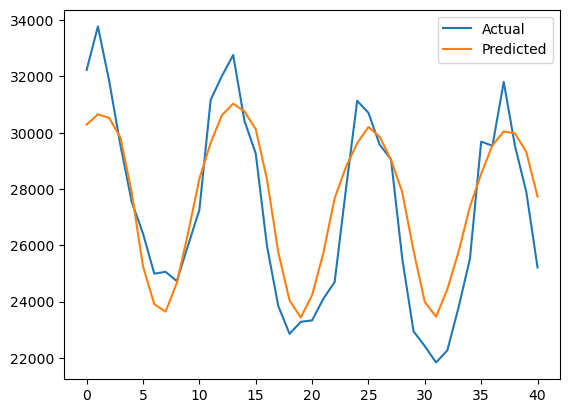

MAPE: 4.976%


In [71]:
plt.plot(yts_gltmc, label='Actual')
plt.plot(pred_gltmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gltmc, pred_gltmc)*100:.3f}%")

### STLF

In [72]:
scaler_gstoc = MinMaxScaler(feature_range=(0, 1))

sctr_gstoc = scaler_gstoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
scvl_gstoc = scaler_gstoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
scts_gstoc = scaler_gstoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)

In [73]:
gstoc_model = Sequential()
gstoc_model.add(InputLayer((SEASON_STLF, 1)))
gstoc_model.add(GRU(128, return_sequences=True))
gstoc_model.add(GRU(128))
gstoc_model.add(Dense(8, 'relu'))
gstoc_model.add(Dense(1, 'linear'))

gstoc_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 6, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,417 (587.57 KB)

 Trainable params: 150,417 (587.57 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
cp = ModelCheckpoint('models/gstoc_model.keras', save_best_only=True)
gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0317 - root_mean_squared_error: 0.1637 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2132
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2062
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

In [75]:
gstoc_model = load_model('models/gstoc_model.keras')

pred_gstoc = gstoc_model.predict(Xts_gstoc)
pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)

yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


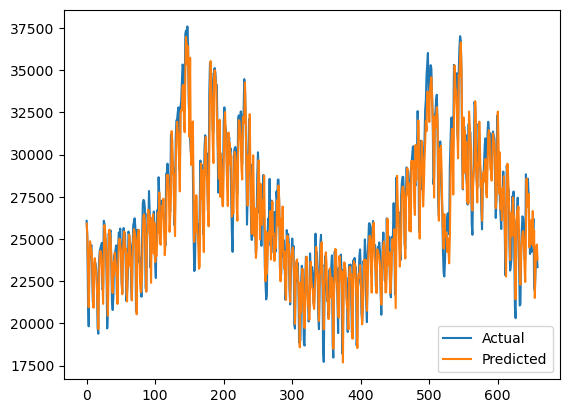

MAPE: 4.282%


In [76]:
plt.plot(yts_gstoc, label='Actual')
plt.plot(pred_gstoc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gstoc, pred_gstoc)*100:.3f}%")

### STLF with Exogenous Variables

In [77]:
scaler_gstmc = MinMaxScaler(feature_range=(0, 1))

sctr_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
scvl_gstmc = scaler_gstmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
scts_gstmc = scaler_gstmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])

Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)

In [78]:
gstmc_model = Sequential()
gstmc_model.add(InputLayer((SEASON_STLF, 4)))
gstmc_model.add(GRU(512, return_sequences=True))
gstmc_model.add(GRU(256))
gstmc_model.add(Dense(32, 'relu'))
gstmc_model.add(Dense(4, 'linear'))

gstmc_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 6, 512)         │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,364 (5.32 MB)

 Trainable params: 1,395,364 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
cp = ModelCheckpoint('models/gstmc_model.keras', save_best_only=True)
gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.2043 - root_mean_squared_error: 0.4498 - val_loss: 0.0915 - val_root_mean_squared_error: 0.3024
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0554 - root_mean_squared_error: 0.2353 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.0717 - val_root_mean_squared_error: 0.2677
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0716 - val_root_mean_squared_error: 0.2675
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2267
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2430
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0296 - roo

In [80]:
gstmc_model = load_model('models/gstmc_model.keras')

pred_gstmc = gstmc_model.predict(Xts_gstmc)
pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]

yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


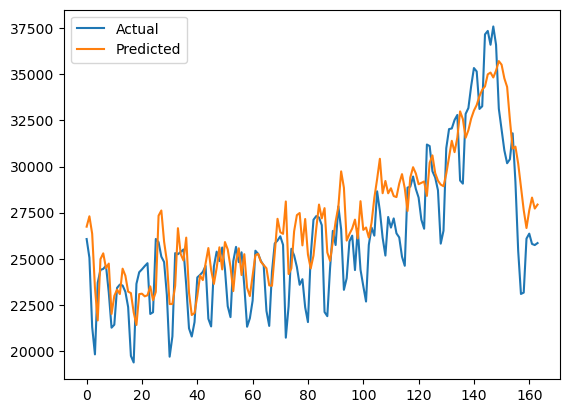

MAPE: 7.277%


In [81]:
plt.plot(yts_gstmc, label='Actual')
plt.plot(pred_gstmc, label='Predicted')
plt.legend()
plt.show()

print(f"MAPE: {mean_absolute_percentage_error(yts_gstmc, pred_gstmc)*100:.3f}%")

## MAPE Averaging

WARNING: do not run unless you are willing to wait for 1.5 - 3hrs (depending on hardware)!

In [82]:
def ltoc_run() -> float:
    scaler_ltoc = MinMaxScaler(feature_range=(0, 1))
    agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_ltoc = scaler_ltoc.fit_transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    scvl_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
    scts_ltoc = scaler_ltoc.fit_transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)
    Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
    Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)
    ltoc_model = Sequential()
    ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    ltoc_model.add(LSTM(128, return_sequences=True))
    ltoc_model.add(LSTM(128))
    ltoc_model.add(Dense(8, 'relu'))
    ltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])
    ltoc_model = load_model('intermediate.keras')
    pred_ltoc = ltoc_model.predict(Xts_ltoc)
    pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)
    yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)
   
    return mean_absolute_percentage_error(yts_ltoc, pred_ltoc) * 100

In [83]:
def gltoc_run() -> float:
    scaler_gltoc = MinMaxScaler(feature_range=(0, 1))
    agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    sctr_gltoc = scaler_gltoc.fit_transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    scvl_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
    scts_gltoc = scaler_gltoc.fit_transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
    Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
    Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)
    gltoc_model = Sequential()
    gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    gltoc_model.add(GRU(128, return_sequences=True))
    gltoc_model.add(GRU(128))
    gltoc_model.add(Dense(8, 'relu'))
    gltoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp])
    gltoc_model = load_model('intermediate.keras')
    pred_gltoc = gltoc_model.predict(Xts_gltoc)
    pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)
    yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)
   
    return mean_absolute_percentage_error(yts_gltoc, pred_gltoc) * 100

In [84]:
def stoc_run() -> float:
    agg_stoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_stoc = MinMaxScaler(feature_range=(0, 1))
    sctr_stoc = scaler_stoc.fit_transform(stoc[stoc.index < pd.to_datetime("2022-05-01")])
    scvl_stoc = scaler_stoc.fit_transform(stoc[(stoc.index >= pd.to_datetime("2022-05-01")) & (stoc.index < pd.to_datetime("2022-07-15"))])
    scts_stoc = scaler_stoc.fit_transform(stoc[stoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
    Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
    Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)
    stoc_model = Sequential()
    stoc_model.add(InputLayer((SEASON_STLF, 1)))
    stoc_model.add(LSTM(128, return_sequences=True))
    stoc_model.add(LSTM(128))
    stoc_model.add(Dense(8, 'relu'))
    stoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp])
    stoc_model = load_model('intermediate.keras')
    pred_stoc = stoc_model.predict(Xts_stoc)
    pred_stoc = scaler_stoc.inverse_transform(pred_stoc)
    yts_stoc = scaler_stoc.inverse_transform(yts_stoc)
    

    return mean_absolute_percentage_error(yts_stoc, pred_stoc) * 100

In [85]:
def gstoc_run() -> float:
    agg_gstoc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].asfreq("D")
    scaler_gstoc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    scvl_gstoc = scaler_gstoc.fit_transform(agg_gstoc[(agg_gstoc.index >= pd.to_datetime("2022-05-01")) & (agg_gstoc.index < pd.to_datetime("2022-07-15"))])
    scts_gstoc = scaler_gstoc.fit_transform(agg_gstoc[agg_gstoc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
    Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
    Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)
    gstoc_model = Sequential()
    gstoc_model.add(InputLayer((SEASON_STLF, 1)))
    gstoc_model.add(GRU(128, return_sequences=True))
    gstoc_model.add(GRU(128))
    gstoc_model.add(Dense(8, 'relu'))
    gstoc_model.add(Dense(1, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp])
    gstoc_model = load_model('intermediate.keras')
    pred_gstoc = gstoc_model.predict(Xts_gstoc)
    pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)
    yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)
    
    return mean_absolute_percentage_error(yts_gstoc, pred_gstoc) * 100

In [86]:
def ltmc_run() -> float:
    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_ltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_ltmc = scaler_ltmc.fit_transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_ltmc = scaler_ltmc.fit_transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
    Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
    Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)
    ltmc_model = Sequential()
    ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    ltmc_model.add(LSTM(512, return_sequences=True))
    ltmc_model.add(LSTM(256))
    ltmc_model.add(Dense(32, 'relu'))
    ltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp])
    ltmc_model = load_model('intermediate.keras')
    pred_ltmc = ltmc_model.predict(Xts_ltmc)
    pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]
    yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

    return mean_absolute_percentage_error(yts_ltmc, pred_ltmc) * 100

In [87]:
def gltmc_run() -> float:
    gltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    scaler_gltmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gltmc = scaler_gltmc.fit_transform(gltmc[gltmc.index < pd.to_datetime("2017-01-01")])
    scvl_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2017-01-01")) & (gltmc.index < pd.to_datetime("2020-01-01"))])
    scts_gltmc = scaler_gltmc.fit_transform(gltmc[(gltmc.index >= pd.to_datetime("2020-01-01")) & (gltmc.index < pd.to_datetime("2024-05-01"))])
    Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
    Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
    Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)
    gltmc_model = Sequential()
    gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    gltmc_model.add(LSTM(512, return_sequences=True))
    gltmc_model.add(LSTM(256))
    gltmc_model.add(Dense(32, 'relu'))
    gltmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp])
    gltmc_model = load_model('intermediate.keras')
    pred_gltmc = gltmc_model.predict(Xts_gltmc)
    pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]
    yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

    return mean_absolute_percentage_error(yts_gltmc, pred_gltmc) * 100

In [88]:
def stmc_run():
    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")
    scaler_stmc = MinMaxScaler(feature_range=(0, 1))
    sctr_stmc = scaler_stmc.fit_transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_stmc = scaler_stmc.fit_transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_stmc = scaler_stmc.fit_transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
    Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
    Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)
    stmc_model = Sequential()
    stmc_model.add(InputLayer((SEASON_STLF, 4)))
    stmc_model.add(LSTM(512, return_sequences=True))
    stmc_model.add(LSTM(256))
    stmc_model.add(Dense(32, 'relu'))
    stmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp])
    stmc_model = load_model('intermediate.keras')
    pred_stmc = stmc_model.predict(Xts_stmc)
    pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]
    yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

    return mean_absolute_percentage_error(yts_stmc, pred_stmc) * 100

In [89]:
def gstmc_run():
    gstmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_wdat_dly).asfreq("D")
    scaler_gstmc = MinMaxScaler(feature_range=(0, 1))
    sctr_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index < pd.to_datetime("2022-05-01")])
    scvl_gstmc = scaler_gstmc.fit_transform(gstmc[(gstmc.index >= pd.to_datetime("2022-05-01")) & (gstmc.index < pd.to_datetime("2022-07-15"))])
    scts_gstmc = scaler_gstmc.fit_transform(gstmc[gstmc.index >= pd.to_datetime("2022-07-15")])
    Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
    Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
    Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)
    gstmc_model = Sequential()
    gstmc_model.add(InputLayer((SEASON_STLF, 4)))
    gstmc_model.add(LSTM(512, return_sequences=True))
    gstmc_model.add(LSTM(256))
    gstmc_model.add(Dense(32, 'relu'))
    gstmc_model.add(Dense(4, 'linear'))
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp])
    gstmc_model = load_model('intermediate.keras')
    pred_gstmc = gstmc_model.predict(Xts_gstmc)
    pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]
    yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

    return mean_absolute_percentage_error(yts_gstmc, pred_gstmc) * 100

In [90]:
"""
results = {
    "ltoc":[], "gltoc":[], "stoc":[], "gstoc":[], "ltmc":[], "gltmc":[], "stmc":[], "gstmc":[]
    }

SyntaxError: incomplete input (1100956393.py, line 1)

In [ ]:
"""
for i in range(15):
    results["ltoc"].append(ltoc_run())

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.2825 - root_mean_squared_error: 0.5311 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5221
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854 - val_loss: 0.2436 - val_root_mean_squared_error: 0.4936
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469 - val_loss: 0.1900 - val_root_mean_squared_error: 0.4359
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1526 - root_mean_squared_error: 0.3896 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3434
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0651 - root_mean_squared_error: 0.2550 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0866 - root_mean_squared_error: 0.2940 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0611 - roo

In [ ]:
"""
for i in range(15):
    results["gltoc"].append(gltoc_run())


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - loss: 0.2579 - root_mean_squared_error: 0.5078 - val_loss: 0.2602 - val_root_mean_squared_error: 0.5101
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2102 - root_mean_squared_error: 0.4581 - val_loss: 0.2363 - val_root_mean_squared_error: 0.4861
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1884 - root_mean_squared_error: 0.4337 - val_loss: 0.2024 - val_root_mean_squared_error: 0.4498
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1509 - root_mean_squared_error: 0.3885 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3925
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0928 - root_mean_squared_error: 0.3047 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3358
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593 - val_loss: 0.1457 - val_root_mean_squared_error: 0.3817
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0835 - ro

In [ ]:
"""
for i in range(15):
    results["stoc"].append(stoc_run())
    print(i)


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0581 - root_mean_squared_error: 0.2251 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2397
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2417
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0571 - val_root_mean_squared_error: 0.2390
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2259
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1836
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

In [ ]:
"""
for i in range(15):
    results["gstoc"].append(gstoc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.2410 - root_mean_squared_error: 0.4896 - val_loss: 0.0569 - val_root_mean_squared_error: 0.2385
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0360 - root_mean_squared_error: 0.1894 - val_loss: 0.1044 - val_root_mean_squared_error: 0.3231
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0590 - root_mean_squared_error: 0.2425 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0223 - root_mean_squared_error: 0.1491 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2394
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0389 - root_mean_squared_error: 0.1970 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2349
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0294 - root_mean_squared_error: 0.1714 - val_loss: 0.0533 - val_root_mean_squared_error: 0.2309
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0237 - roo

In [ ]:
"""
for i in range(15):
    results["ltmc"].append(ltmc_run())
    print(i)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - loss: 0.2266 - root_mean_squared_error: 0.4758 - val_loss: 0.1771 - val_root_mean_squared_error: 0.4209
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1273 - root_mean_squared_error: 0.3565 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3351
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0786 - root_mean_squared_error: 0.2802 - val_loss: 0.0950 - val_root_mean_squared_error: 0.3082
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2917
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0673 - root_mean_squared_error: 0.2594 - val_loss: 0.0762 - val_root_mean_squared_error: 0.2760
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371 - val_loss: 0.0797 - val_root_mean_squared_error: 0.2823
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0499 

In [ ]:
"""
for i in range(15):
    results["gltmc"].append(gltmc_run())
    print(i)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - loss: 0.1810 - root_mean_squared_error: 0.4250 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3225
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0736 - root_mean_squared_error: 0.2712 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2920
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.1039 - val_root_mean_squared_error: 0.3224
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0697 - root_mean_squared_error: 0.2639 - val_loss: 0.0858 - val_root_mean_squared_error: 0.2928
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2926
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2799
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0525 - 

In [ ]:
"""
for i in range(15):
    results["stmc"].append(stmc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.1886 - root_mean_squared_error: 0.4325 - val_loss: 0.0885 - val_root_mean_squared_error: 0.2975
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0784 - root_mean_squared_error: 0.2794 - val_loss: 0.0814 - val_root_mean_squared_error: 0.2852
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0588 - root_mean_squared_error: 0.2424 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0424 - root_mean_squared_error: 0.2055 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2496
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2559
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2382
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0340 - roo

In [ ]:
"""
for i in range(15):
    results["gstmc"].append(gstmc_run())
    print(i)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.2078 - root_mean_squared_error: 0.4541 - val_loss: 0.0771 - val_root_mean_squared_error: 0.2777
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0680 - root_mean_squared_error: 0.2606 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2721
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2714
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2342
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0325 - root_mean_squared_error: 0.1801 - val_loss: 0.0681 - val_root_mean_squared_error: 0.2609
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0333 - roo

In [ ]:
"""
mean_list = [np.mean(results["ltoc"]), np.mean(results["gltoc"]), np.mean(results["stoc"]), np.mean(results["gstoc"]), 
np.mean(results["ltmc"]), np.mean(results["gltmc"]), np.mean(results["stmc"]), np.mean(results["gstmc"])]

mean_list

[3.9398934274077235,
 3.246422811156406,
 4.774558596377669,
 6.520666214466544,
 7.0820280159042985,
 7.241012849284248,
 9.542898512019125,
 8.773331698280268]

In [ ]:
"""
std_list = [np.std(results["ltoc"]), np.std(results["gltoc"]), np.std(results["stoc"]), np.std(results["gstoc"]), 
np.std(results["ltmc"]), np.std(results["gltmc"]), np.std(results["stmc"]), np.std(results["gstmc"])]

std_list

[0.8284301929700736,
 0.24321273199237317,
 0.200225718288764,
 0.4399720496446394,
 0.8206419010028283,
 1.369446244354824,
 1.9370215733765481,
 1.4725708828192492]

In [ ]:
"""
def conf_interval_15(mean: float, std: float) -> (float, float):
    return (mean - std * 2.131, mean, mean + std * 2.131)

In [ ]:
"""
for m, s in zip(mean_list, std_list):
    print(conf_interval_15(m, s))

(2.1745086861884966, 3.9398934274077235, 5.7052781686269505)
(2.728136479280659, 3.246422811156406, 3.764709143032153)
(4.347877590704313, 4.774558596377669, 5.201239602051025)
(5.583085776673818, 6.520666214466544, 7.4582466522592705)
(5.333240124867272, 7.0820280159042985, 8.830815906941325)
(4.322722902564118, 7.241012849284248, 10.159302796004377)
(5.415105539153702, 9.542898512019125, 13.670691484884548)
(5.635283146992448, 8.773331698280268, 11.911380249568088)


### Results

Confidence intervals at 95% of MAPE:
```
model   (lower bound,        mean,             upper bound)
-----------------------------------------------------------------
ltoc    (2.174508686188497, 3.939893427407724, 5.705278168626951)
glotc   (2.728136479280659, 3.246422811156406, 3.764709143032153)
stoc    (4.347877590704313, 4.774558596377669, 5.201239602051025)
gstoc   (5.583085776673818, 6.520666214466544, 7.458246652259271)
ltmc    (5.333240124867272, 7.082028015904299, 8.830815906941325)
gltmc   (4.322722902564118, 7.241012849284248, 10.15930279600438)
stmc    (5.415105539153702, 9.542898512019125, 13.67069148488455)
gstmc   (5.635283146992448, 8.773331698280268, 11.91138024956809)
```